# Comparison of Regression, Classification Algorithms on Diamonds Dataset

+ **Author:** Usman Tariq
+ **Email:** usm6329@gmail.com

> **About Dataset:**\
> We will use the `diamonds` dataset from the seaborn library.

> **Purpose:**
> + Finding the Best Regression & Classification Algorithms with well perfomed parameters.
> + We will apply the regressors and classifiers of the following algorithms to the above mentioned dataset:
>   01. Logistic Regression
>   02. Random Forest
>   03. Decision Tree
>   04. Gradient Boosting
>   05. Support Vector Machine
>   06. K-Nearest Neighbors
>   07. Extra Gradient Boosting
>   08. Ada Boost
>   09. Bagging
>   10. CatBoost
>   11. Light GBM
>   12. XGBoost
>   13. Naive Bayes
> + We will apply the `Hyperparameter Tuning` and select the best algorithms based on the following metrics:
>   + Accuracy Score / Mean Absolute Error
>   + Recall Score / Mean Squared Error
>   + Precision Score / R2 Score
>   + F1 Score / Mean Absolute Percentage Error
> + We will save the best selected algorithms with well performed parameters.
> + We will load the saved classification & regression models, and test on a dummy inputs, respectively.

## Regression Models Comparisons

**Import Libraries and Regression Models**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import warnings
warnings.filterwarnings('ignore')
from scipy.stats import skew
from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from time import time
import pickle

**Load Dataset**

In [4]:
df = sns.load_dataset('diamonds')
# df = df_full.sample(10000, random_state=42)
df.sample(2)

,carat,cut,color,clarity,depth,table,price,x,y,z
46296,0.3,Premium,I,VVS2,61.0,60.0,526,4.30,4.36,2.64
15743,1.0,Premium,F,VS2,62.9,59.0,6296,6.47,6.40,4.02


**Data Overview**

In [5]:
df.shape

(53940, 10)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   carat    53940 non-null  float64 
 1   cut      53940 non-null  category
 2   color    53940 non-null  category
 3   clarity  53940 non-null  category
 4   depth    53940 non-null  float64 
 5   table    53940 non-null  float64 
 6   price    53940 non-null  int64   
 7   x        53940 non-null  float64 
 8   y        53940 non-null  float64 
 9   z        53940 non-null  float64 
dtypes: category(3), float64(6), int64(1)
memory usage: 3.0 MB


<Axes: >

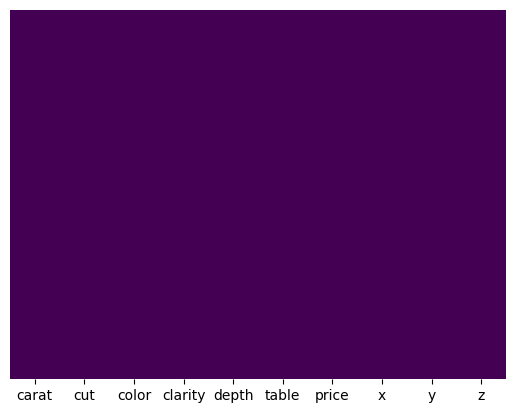

In [7]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

> **Observations:**
> + There are 3 categorical features ['cut', 'color', 'clarity'].
> + There are 7 numerical features ['carat', 'depth', 'table', 'price', 'x', 'y', 'z'].
> + There is no missing data in the dataframe.

**Data Preprocessing**

+ Encode the Categorical features by using Label Encoder.

In [8]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

le = LabelEncoder()

for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

+ Inspect the "multicolinearity".

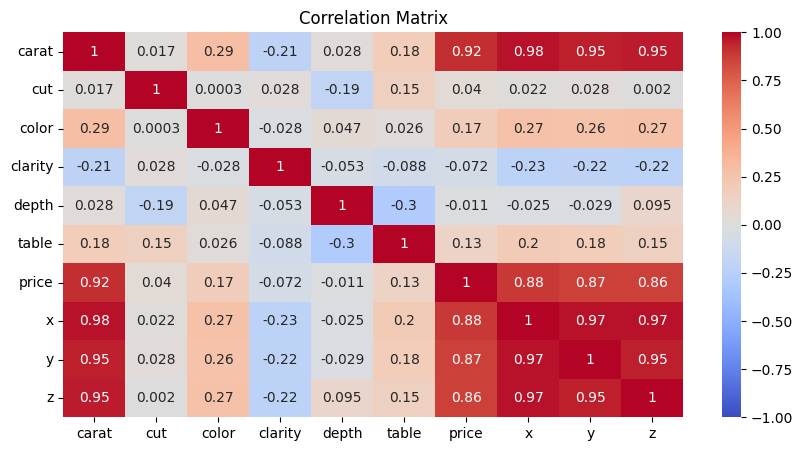

In [9]:
# create heatmap of correlation matrix
corr_matrix = df.corr()

plt.figure(figsize=(10, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

> **Observations:**
> + The features ['x', 'y', 'z', 'carat'] are highly correlated with eachother.
> + The correlation of ['carat'] is higher than ['x', 'y', 'z'], with target feature ['price'].
> + So, we remove the ['x', 'y', 'z'] features to remove multicolinearity.
> + The features ['carat', 'clarity'] are negatively correlated at low level.
> + The features ['cut', 'depth'] are also negatively correlated at low level.
>
> + The features ['depth', 'table'] are also negatively correlated at below-moderate level.

+ Remove the highly correlated features based on the above observations.

In [10]:
df.drop(['x', 'y', 'z'], axis=1, inplace=True)

In [11]:
df.sample(2)

,carat,cut,color,clarity,depth,table,price
40765,0.62,3,6,5,61.2,59.0,1166
4085,0.77,2,2,5,61.8,56.0,3533


+ Inspect the Data Distributions and Outliers.

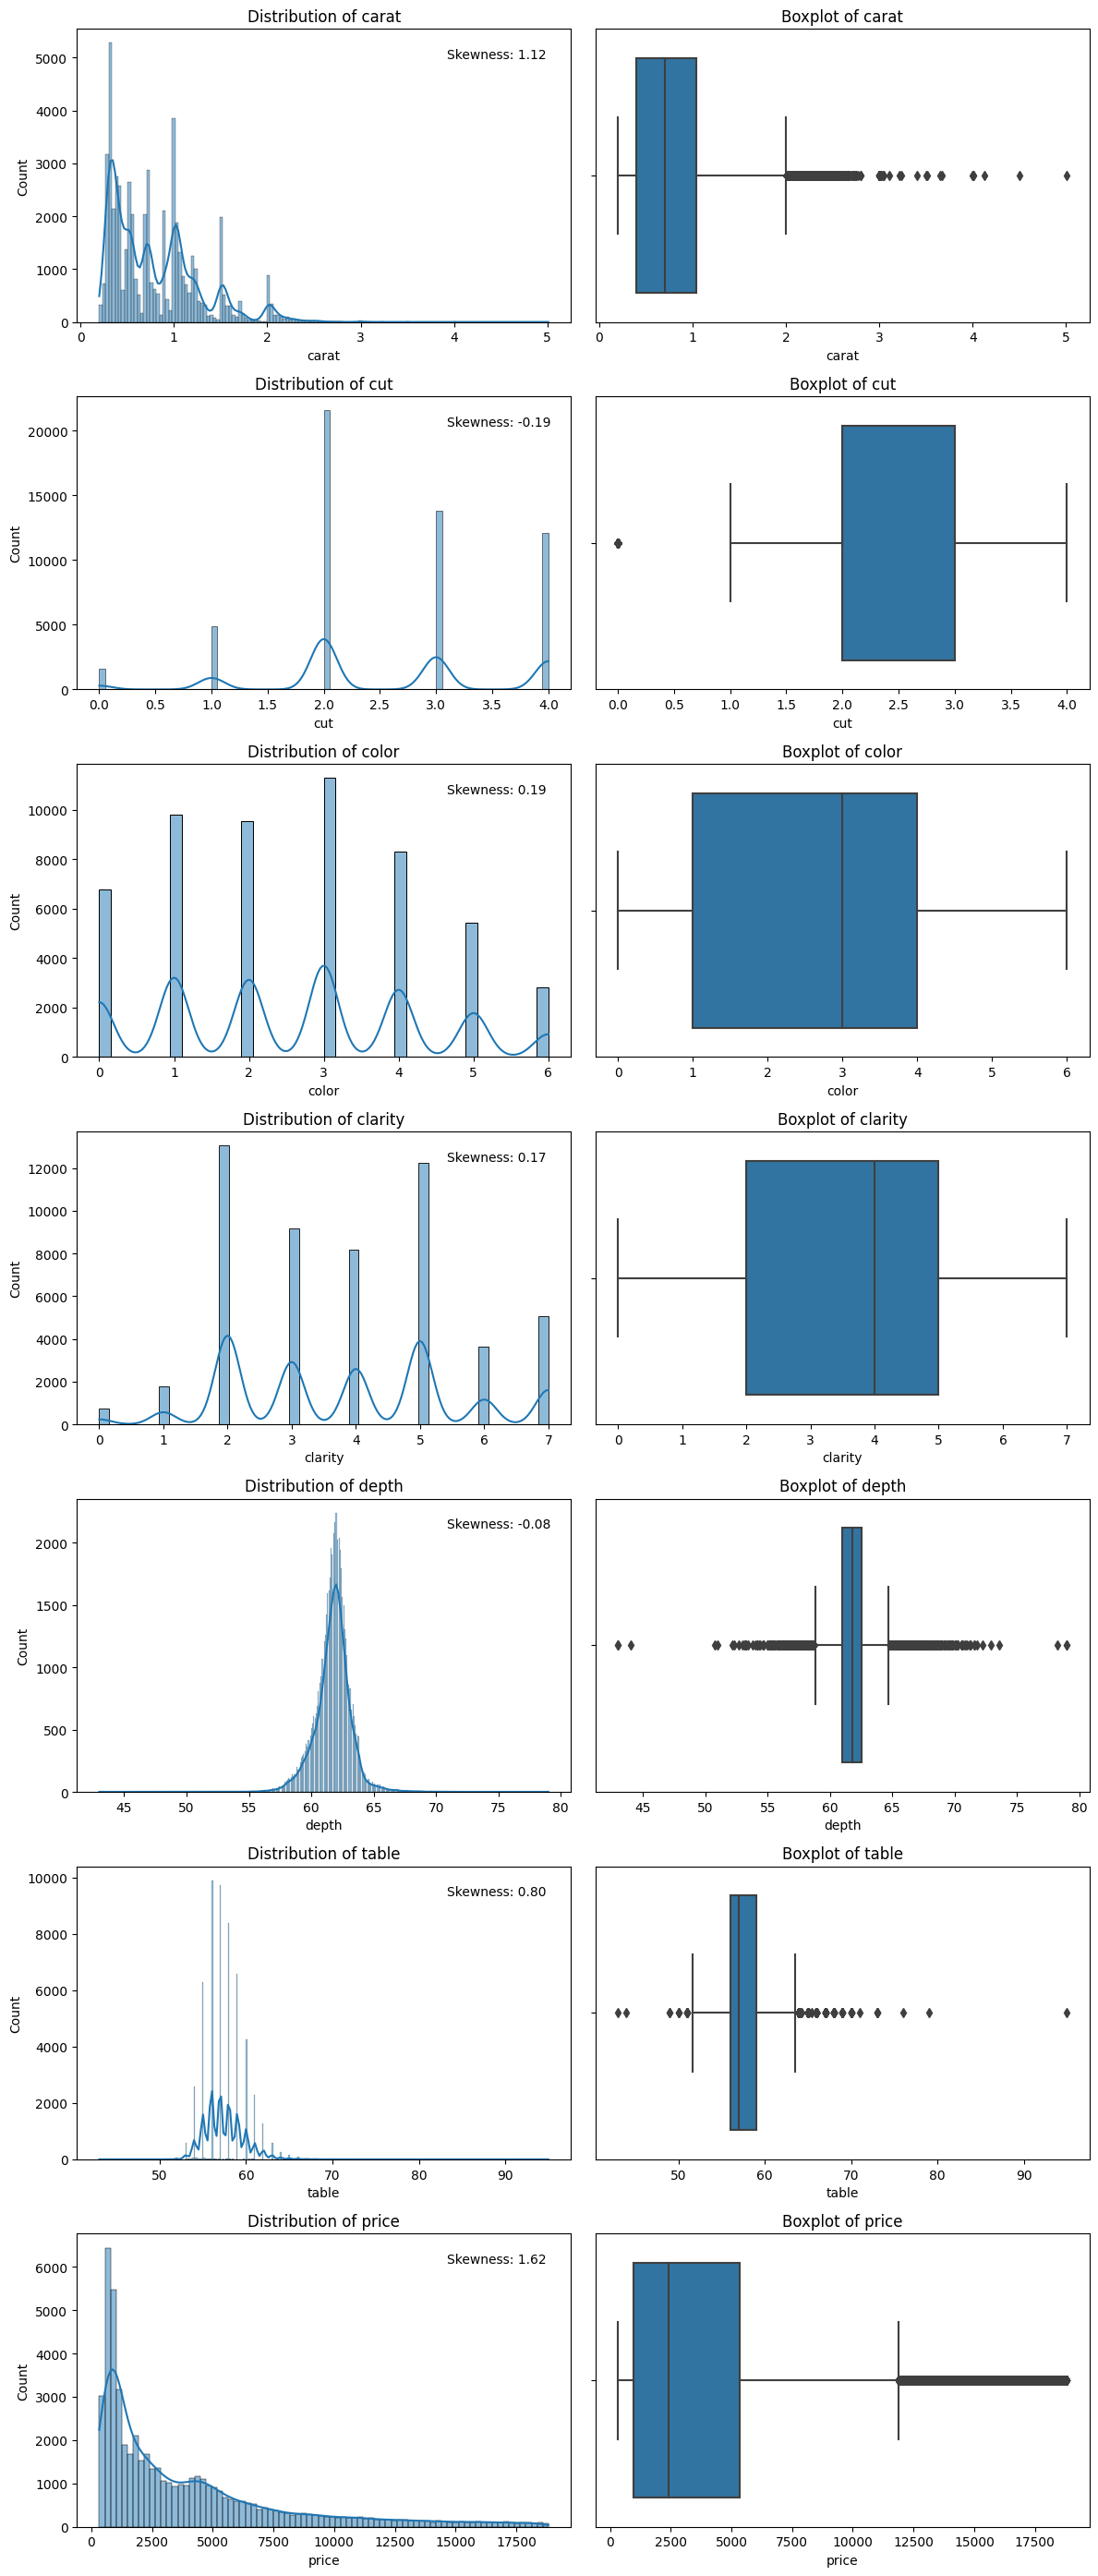

CPU times: user 7.58 s, sys: 1.12 s, total: 8.7 s
Wall time: 7.62 s


In [12]:
%%time
# Determine the number of rows and columns based on the number of features
num_features = len(df.columns)
num_rows = num_features
num_cols = 2

# Set the figure size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4*num_rows))

# Flatten the axes array to facilitate indexing
axes = axes.flatten()

# Loop through each column in df.columns and plot the distribution, boxplot, and skewness
for i, col in enumerate(df.columns):
    # Plot the distribution
    sns.histplot(df[col], kde=True, ax=axes[2*i])
    axes[2*i].set_title(f'Distribution of {col}')

    # Add skewness value as text within the plot
    skewness = skew(df[col])
    axes[2*i].text(0.75, 0.9, f'Skewness: {skewness:.2f}', transform=axes[2*i].transAxes)

    # Plot the boxplot
    sns.boxplot(x=df[col], ax=axes[2*i+1])
    axes[2*i+1].set_title(f'Boxplot of {col}')

# Adjust the layout and show the plots
plt.tight_layout()
plt.show()

+ Apply the Quantile Trnasformation to normalize the data.

In [13]:
qt = QuantileTransformer(output_distribution='normal')

# Apply the transformation to your data
for col in df.columns:
    df[col] = qt.fit_transform(df[[col]])

**Apply the Regression Models based on above Preprocessing Steps**

In [14]:
df = sns.load_dataset('diamonds')
# df = df_full.sample(10000, random_state=42)
df.sample(2)

,carat,cut,color,clarity,depth,table,price,x,y,z
14508,1.01,Premium,D,SI1,61.5,59.0,5860,6.46,6.39,3.95
5463,1.23,Very Good,H,I1,61.9,60.6,3835,6.79,6.85,4.22


In [15]:
models = {
    'Linear Regression': (LinearRegression(), {}),
    'Random Forest Regression': (RandomForestRegressor(), {'n_estimators': [50]}
                                #  {'n_estimators': [50, 100, 200],
                                #   'max_depth': [None, 10, 20, 30],
                                #   'min_samples_split': [2, 5, 10],
                                #   'min_samples_leaf': [1, 2, 4]}
                                  ),
    'Decision Tree Regression': (DecisionTreeRegressor(), {'max_depth':[5]}
                                #  {'max_depth': [None, 10, 20, 30],
                                #  'min_samples_split': [2, 5, 10],
                                #  'min_samples_leaf': [1, 2, 4]}
                                 ),
    'XGBoost Regression': (XGBRegressor(), {'n_estimators': [50]}
                        #    {'n_estimators': [50, 100, 200],
                        #     'learning_rate': [0.001, 0.01, 0.1, 1],
                        #     'max_depth': [3, 5, 7],
                        #     'gamma': [0, 0.1, 0.2, 0.3]}
                            ),
    'AdaBoost Regression': (AdaBoostRegressor(), {'n_estimators': [50]}
                            # {'n_estimators': [50, 100, 200],
                            #  'learning_rate': [0.001, 0.01, 0.1, 1]}
                             ),
    'Gradient Boosting Regression': (GradientBoostingRegressor(), {'n_estimators': [50]}
                                    #  {'n_estimators': [50, 100, 200],
                                    #   'learning_rate': [0.001, 0.01, 0.1, 1],
                                    #   'max_depth': [3, 5, 7]}
                                      ),
    'Support Vector Machine': (SVR(), {'C':[0.1]}
                            #    {'C': [0.001, 0.01, 0.1, 1, 10],
                            #     'kernel': ['linear', 'rbf'],
                            #     'gamma': ['scale', 'auto']}
                                ),
    'K-Nearest Regression': (KNeighborsRegressor(), {'n_neighbors':[3]}
                            #  {'n_neighbors': [3, 5, 7],
                            #   'weights': ['uniform', 'distance'],
                            #   'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
                              ),
    'Extra Gradient Boosting Regression': (ExtraTreesRegressor(), {'n_estimators': [50]}
                                        #    {'n_estimators': [50, 100, 200],
                                        #     'max_depth': [None, 10, 20, 30],
                                        #     'min_samples_split': [2, 5, 10],
                                        #     'min_samples_leaf': [1, 2, 4]}
                                            ),
    'Bagging Regression': (BaggingRegressor(), {'n_estimators': [50]}
                        #    {'n_estimators': [50, 100, 200],
                        #     'max_samples': [1.0, 0.8, 0.6],
                        #     'max_features': [1.0, 0.8, 0.6]}
                            ),
    'CatBoost Regression': (CatBoostRegressor(verbose=False), {'n_estimators': [50]}
                            # {'n_estimators': [50, 100, 200],
                            #  'learning_rate': [0.001, 0.01, 0.1, 1],
                            #  'depth': [4, 6, 8, 10]}
                             ),
    'Light GBM Regression': (LGBMRegressor(verbose=-1), {'n_estimators': [50], 'learning_rate':[0.01]}
                            #  {'n_estimators': [50, 100, 200],
                            #   'learning_rate': [0.001, 0.01, 0.1, 1]}
                              ),
    # 'Guassian Naive Bayes': (GaussianNB(), {}),
}

In [16]:
%%time
X = df.drop(['x', 'y', 'z','price'], axis=1)
y = df['price']

# Apply the Quantile Transformation to the target variable.
y_qt = QuantileTransformer(output_distribution='normal')
y = pd.Series(y_qt.fit_transform(y.values.reshape(-1, 1)).ravel())

numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

numeric_transformer = Pipeline(steps=[
    ('quantile_transformer', QuantileTransformer(output_distribution='normal'))
])
categorical_transformer = Pipeline(steps=[
    ('one hot encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Create a DataFrame to store results
results_table = pd.DataFrame(columns=['Model', 'Mean MAE', 'Mean RMSE', 'Mean R2', 'Mean MAPE'])

# Evaluate models and select the best based on multiple metrics
best_model = None
current_RMSE = float('inf')
best_model_params = None

for model_name, (model, original_param_grid) in models.items():
    start_time = time()  # Record the start time
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])

    # Include classifier name in the parameter grid for GridSearchCV
    param_grid = {f'classifier__{key}': value for key, value in original_param_grid.items()}

    # Define a composite scoring function (you can customize weights based on your preferences)
    scoring = {
        'MAE': 'neg_mean_absolute_error',
        'RMSE': 'neg_root_mean_squared_error',
        'R2': 'r2',
        'MAPE': 'neg_mean_absolute_percentage_error'
    }

    # Use cross-validation with the composite scoring function
    grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring=scoring, refit='RMSE', return_train_score=False)
    grid_search.fit(X, y)

    end_time = time()
    runtime = end_time - start_time

    # Convert run_time to minutes and seconds
    minutes, seconds = divmod(runtime, 60)
    formatted_time = "{:0>2}:{:05.2f}".format(int(minutes), seconds)

    # Get the best model and its performance on multiple metrics
    best_model_name = model_name
    # best_model_params = grid_search.best_params_
    results = grid_search.cv_results_

    # Calculate mean scores for each fold
    mean_MAE = -results["mean_test_MAE"].mean()
    mean_RMSE = -results["mean_test_RMSE"].mean()
    mean_R2 = results["mean_test_R2"].mean()
    mean_MAPE = -results["mean_test_MAPE"].mean()

    columns=['Model', 'Mean MAE', 'Mean RMSE', 'Mean R2', 'Mean MAPE']
    # Instead of results_table = results_table.append(...)
    results_table = pd.concat([results_table, pd.DataFrame([{'Model': model_name,
                                                          'Mean MAE': mean_MAE,
                                                          'Mean RMSE': mean_RMSE,
                                                          'Mean R2': mean_R2,
                                                          'Mean MAPE': mean_MAPE,
                                                          'Runtime': formatted_time}])], ignore_index=True)

    # Update the best model if the current model has a better composite score
    if mean_RMSE < current_RMSE:
        current_RMSE = mean_RMSE
        # lower_R2 = mean_R2
        best_model = best_model_name
        best_model_params = grid_search.best_params_

# Display the results table
print('\nResults of Applied Models:')
print(results_table.to_string(index=False, line_width=1000))
# print(pd.DataFrame(results_table))

print('------------------------------------------')
print(f'\nBest Selected Model based on RMSE: {best_model}')
print(f'Best Hyperparameters: {best_model_params}')


Results of Applied Models:
                             Model  Mean MAE  Mean RMSE  Mean R2  Mean MAPE  Runtime
                 Linear Regression  0.262854   0.341904 0.764140   2.947785 00:00.77
          Random Forest Regression  0.325498   0.403556 0.764279   1.691623 09:10.88
          Decision Tree Regression  0.505660   0.581790 0.435684   2.633344 00:00.68
                XGBoost Regression  0.285820   0.353755 0.814955   1.202559 00:01.55
               AdaBoost Regression  0.572291   0.671658 0.056364   6.736521 00:10.97
      Gradient Boosting Regression  0.407163   0.486131 0.638560   1.953506 00:06.15
            Support Vector Machine  0.276625   0.376783 0.785202   2.449344 04:07.27
              K-Nearest Regression  0.432101   0.533815 0.499040   4.114318 01:40.24
Extra Gradient Boosting Regression  0.304475   0.384497 0.796279   1.409207 10:52.97
                Bagging Regression  0.327363   0.405302 0.761132   1.707384 08:54.78
               CatBoost Regression  0

**Save the Best Performed Regressor**

In [17]:
print(best_model,"\n", best_model_params)

CatBoost Regression 
 {'classifier__n_estimators': 50}


In [18]:
# Extract the best model's hyperparameters
best_model_params = {key.replace('classifier__', ''): value for key, value in best_model_params.items()}

In [ ]:
# Instantiate the best model with its parameters
selected_model = CatBoostRegressor(**best_model_params)

# Create the regression pipeline with the selected model
best_regression_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', selected_model)
])

# Fit the pipeline on the training data
best_regression_pipeline.fit(X, y)

# Save the trained pipeline to a file
with open('best_regression_model.pkl', 'wb') as model_file:
    pickle.dump(best_regression_pipeline, model_file)


**Load the Saved Model**

In [20]:
# Load the saved model from file
with open('best_regression_model.pkl', 'rb') as model_file:
    loaded_model = pickle.load(model_file)

**Test the Loaded Model**

In [21]:
def predict_price():
    x = pd.DataFrame({
        'carat': [0.69],
        'cut': ['Ideal'],
        'color': ['E'],
        'clarity': ['VS1'],
        'depth': [59.9],
        'table': [49.3]
    })

    prediction = loaded_model.predict(x)
    pred = y_qt.inverse_transform(prediction.reshape(-1, 1)).ravel()

    print(f"Predicted Price: {pred[0]:.0f}")

In [22]:
predict_price()

Predicted Price: 2551


## Classification Models Comparisons

**Import Libraries and Classification Models**

In [23]:
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings("ignore")

# Set the maximum number of columns to display
pd.set_option('display.max_columns', None)

**Loading the dataset**

In [24]:
# loading the dataset
df = sns.load_dataset('diamonds')
# df = df_full.sample(10000, random_state=42)
df.sample(3)

,carat,cut,color,clarity,depth,table,price,x,y,z
14021,1.00,Good,G,VS2,63.4,57.0,5702,6.27,6.31,3.99
32814,0.34,Ideal,E,VS1,62.0,56.0,805,4.48,4.52,2.79
34526,0.33,Premium,G,VVS1,60.9,58.0,868,4.43,4.47,2.71


**Data Overview**

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   carat    53940 non-null  float64 
 1   cut      53940 non-null  category
 2   color    53940 non-null  category
 3   clarity  53940 non-null  category
 4   depth    53940 non-null  float64 
 5   table    53940 non-null  float64 
 6   price    53940 non-null  int64   
 7   x        53940 non-null  float64 
 8   y        53940 non-null  float64 
 9   z        53940 non-null  float64 
dtypes: category(3), float64(6), int64(1)
memory usage: 3.0 MB


**Applying the Different Models for Classification Problem**

In [27]:
%%time
# Assume 'cut' is the target variable
X = df.drop('cut', axis=1)
y = df['cut']

# Apply ordinal encoder to the target variable y.
y_label_encoder = LabelEncoder()
y = y_label_encoder.fit_transform(y)

# Define transformers for numerical and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['category', 'object']).columns

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Use ColumnTransformer to apply transformers to different feature types
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define models with hyperparameter grids for tuning
models = {
    'Logistic Regression': (LogisticRegression(multi_class='multinomial', solver='lbfgs'), {'C': [0.1]}
                            # {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
                            ),
    'XGBoost': (XGBClassifier(), {'n_estimators': [100]}
                                  #   {'n_estimators': [50, 100, 200],
                                  #  'learning_rate': [0.001, 0.01, 0.1, 1],
                                  #  'max_depth': [3, 5, 7],
                                  #  'gamma': [0, 0.1, 0.2, 0.3]}
                ),
    'Random Forest': (RandomForestClassifier(), {'n_estimators': [100]}
                                                #   {'n_estimators': [50, 100, 200],
                                                #  'max_depth': [None, 10, 20, 30],
                                                #  'min_samples_split': [2, 5, 10],
                                                #  'min_samples_leaf': [1, 2, 4]}
                      ),
    'Decision Tree': (DecisionTreeClassifier(), {'max_depth': [20]}
                                                #   {'max_depth': [None, 10, 20, 30],
                                                #  'min_samples_split': [2, 5, 10],
                                                #  'min_samples_leaf': [1, 2, 4]}
                      ),
    'Gradient Boosting': (GradientBoostingClassifier(), {'n_estimators': [100]}
                                                        #   {'n_estimators': [50, 100, 200],
                                                        #  'learning_rate': [0.001, 0.01, 0.1, 1],
                                                        #  'max_depth': [3, 5, 7]}
                          ),
    'SVM': (SVC(), {'C': [0.01]}
                    # {'C': [0.001, 0.01, 0.1, 1, 10],
                    # 'kernel': ['linear', 'rbf'],
                    # 'gamma': ['scale', 'auto']}
            ),
    'KNN': (KNeighborsClassifier(), {'n_neighbors': [10]}
                                    #   {'n_neighbors': [3, 5, 7],
                                    #  'weights': ['uniform', 'distance'],
                                    #  'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
            ),
    'Extra Gradient': (ExtraTreesClassifier(), {'n_estimators': [100]}
                                                # {'n_estimators': [50, 100, 200],
                                                # 'max_depth': [None, 10, 20, 30],
                                                # 'min_samples_split': [2, 5, 10],
                                                # 'min_samples_leaf': [1, 2, 4]}
                       ),
    'Ada Boost': (AdaBoostClassifier(), {'n_estimators': [100]}
                                        #   {'n_estimators': [50, 100, 200],
                                        #  'learning_rate': [0.001, 0.01, 0.1, 1]}
                  ),
    'Bagging': (BaggingClassifier(), {'n_estimators': [100]}
                                      #   {'n_estimators': [50, 100, 200],
                                      #  'max_samples': [1.0, 0.8, 0.6],
                                      #  'max_features': [1.0, 0.8, 0.6]}
                ),
    'CatBoost': (CatBoostClassifier(verbose=False), {'n_estimators': [100]}
                                                    # {'n_estimators': [50, 100, 200],
                                                    #   'learning_rate': [0.001, 0.01, 0.1, 1],
                                                    #   'depth': [4, 6, 8, 10]}
                 ),
    'Light GBM': (LGBMClassifier(verbose=-1), {'n_estimators': [100]}
                                              # {'n_estimators': [50, 100, 200],
                                              #  'learning_rate': [0.001, 0.01, 0.1, 1],
                                              #   'max_depth': [3, 5, 7]}
                  ),

    'Naive Bayes': (GaussianNB(), {})
}

# Create a DataFrame to store results
results_table = pd.DataFrame(columns=['Model', 'Mean Accuracy', 'Mean Precision', 'Mean Recall', 'Mean F1'])

# Evaluate models and select the best based on multiple metrics
best_model = None
best_composite_score = 0
best_model_params = None

for model_name, (model, original_param_grid) in models.items():
    start_time = time()  # Record the start time
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', model)])

    # Include classifier name in the parameter grid for GridSearchCV
    param_grid = {f'classifier__{key}': value for key, value in original_param_grid.items()}

    # Define a composite scoring function (you can customize weights based on your preferences)
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision_weighted',
        'recall': 'recall_weighted',
        'f1': 'f1_weighted'
    }

    # Use cross-validation with the composite scoring function
    grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring=scoring, refit='f1', return_train_score=False)
    grid_search.fit(X, y)

    end_time = time()
    runtime = end_time - start_time

    # Convert run_time to minutes and seconds
    minutes, seconds = divmod(runtime, 60)
    formatted_time = "{:0>2}:{:05.2f}".format(int(minutes), seconds)

    # Get the best model and its performance on multiple metrics
    best_model_name = model_name
    results = grid_search.cv_results_

    # print("Well Performed Hyperparameters of",model_name,":\n",grid_search.best_params_)

    # Calculate mean scores for each fold
    mean_accuracy = results["mean_test_accuracy"].mean()
    mean_precision = results["mean_test_precision"].mean()
    mean_recall = results["mean_test_recall"].mean()
    mean_f1 = results["mean_test_f1"].mean()

    # Instead of results_table = results_table.append(...)
    results_table = pd.concat([results_table, pd.DataFrame([{'Model': model_name,
                                                          'Mean Accuracy': mean_accuracy,
                                                          'Mean Precision': mean_precision,
                                                          'Mean Recall': mean_recall,
                                                          'Mean F1': mean_f1,
                                                          'Runtime': formatted_time}])], ignore_index=True)

    # Update the best model if the current model has a better composite score
    if mean_f1 > best_composite_score:
        best_model = best_model_name
        best_composite_score = mean_f1
        best_model_params = grid_search.best_params_

# Display the results table
print('\nResults of Applied Models:')
print(results_table.to_string(index=False, line_width=1000))
# print(pd.DataFrame(results_table))

print('------------------------------------------')
print(f'\nBest Selected Model based on F1 Score: {best_model}')
print(f'Best Hyperparameters: {best_model_params}')


Results of Applied Models:
              Model  Mean Accuracy  Mean Precision  Mean Recall  Mean F1  Runtime
Logistic Regression       0.592788        0.574679     0.592788 0.559661 00:06.18
            XGBoost       0.493530        0.552057     0.493530 0.477361 00:13.42
      Random Forest       0.461717        0.515459     0.461717 0.450384 00:29.85
      Decision Tree       0.467223        0.506425     0.467223 0.451459 00:02.26
  Gradient Boosting       0.545699        0.575590     0.545699 0.526601 02:29.22
                SVM       0.545736        0.543921     0.545736 0.504013 08:52.34
                KNN       0.536819        0.531767     0.536819 0.506612 00:16.62
     Extra Gradient       0.427772        0.482972     0.427772 0.402886 00:23.71
          Ada Boost       0.509436        0.559731     0.509436 0.478072 00:17.64
            Bagging       0.486819        0.542054     0.486819 0.475414 01:44.91
           CatBoost       0.565777        0.588880     0.565777 0.5509

**Observation:**
+ Minor difference in the performance of `Logistic Regression` and `CatBoost` Classifiers.
+ So, we can conclude that the `CatBoost` performed well in both cases, regression and classification.

**Save the Best Selected Model**

In [28]:
# Convert best_model_params to a dictionary
best_model_params = {key.replace('classifier__', ''): value for key, value in best_model_params.items()}

In [29]:
# Instantiate the best model with its parameters
selected_model = LogisticRegression(**best_model_params)

# Create the regression pipeline with the selected model
best_classification_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', selected_model)
])

# Fit the pipeline on the training data
best_classification_pipeline.fit(X, y)

# Save the trained pipeline to a file
with open('best_regression_model.pkl', 'wb') as model_file:
    pickle.dump(best_classification_pipeline, model_file)

**Load the Saved Model and Test with Dummy Inputs**

In [31]:
# Load the best model from the saved file (for testing purpose)
with open('best_regression_model.pkl', 'rb') as model_file:
    loaded_model = pickle.load(model_file)

def prediction(input_data):
    prediction = (loaded_model.predict(input_data)).astype(int)
    # print(f"Predicted Diamond Category: {prediction}")
    pred = y_label_encoder.inverse_transform(prediction)
    print(f"Predicted Diamond Category: {pred}")



In [32]:
# Create a dummy dataframe for the input variables.
dummy_inputs_1 = pd.DataFrame({
    'carat': [0.8],
    'color': ['G'],
    'clarity': ['SI1'],
    'depth': [40.5],
    'table': [33.0],
    'price': [4401],
    'x': [4.88],
    'y': [4.66],
    'z': [2.9]
})
prediction(dummy_inputs_1)

Predicted Diamond Category: ['Ideal']


In [33]:
# Create another dummy dataframe for the input variables.
dummy_inputs_2 = pd.DataFrame({
    'carat': [1.2],
    'color': ['D'],
    'clarity': ['VS2'],
    'depth': [60.5],
    'table': [53.1],
    'price': [5401],
    'x': [3.88],
    'y': [3.66],
    'z': [2.9]
})
prediction(dummy_inputs_2)

Predicted Diamond Category: ['Ideal']
